In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb

In [2]:
%%time

version='v_4_2019-04-03'
workdir=os.getcwd()+'/'+version
os.chdir(workdir)
os.makedirs('fig', exist_ok=True)
fig_dir=workdir+'/fig'
algo_name=['T23', 'S', 'S0', 'S10', 'S20', 'T', 'T0', 'T10', 'T20']
algo={}
for i in range(len(algo_name)):
    algo[i]=pd.read_csv(workdir+'/data/{}.csv'.format(algo_name[i]))

CPU times: user 54.8 s, sys: 3.86 s, total: 58.7 s
Wall time: 58.8 s


In [3]:
%%time
#cut
ptcut=10
etamin=1.6
etamax=2.9
algo_cut={}
for i in algo:
    sel=algo[i]['genpart_pt']>ptcut
    algo_cut[i]=algo[i][sel]
    sel=np.abs(algo_cut[i]['genpart_exeta'])>etamin
    algo_cut[i]=algo_cut[i][sel]
    sel=np.abs(algo_cut[i]['genpart_exeta'])<etamax
    algo_cut[i]=algo_cut[i][sel]
    algo_cut[i].dropna(inplace=True)
    algo_cut[i]['genpart_pid'].replace([-11,11],0, inplace=True)
    algo_cut[i]['genpart_pid'].replace([-211,211],1, inplace=True)

CPU times: user 9.24 s, sys: 6.19 s, total: 15.4 s
Wall time: 15.5 s


In [4]:
from sklearn.model_selection import train_test_split
columns=['cl3d_eta','cl3d_showerlength',
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean','genpart_pt']


X_train={}
X_test={}
y_train={}
y_test={}

for i in algo:
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(algo_cut[i][columns], algo_cut[i]['genpart_pid'], test_size=0.2)

In [5]:
X_pt={}
for i in algo:
    X_pt[i]=X_test[i]['genpart_pt']
    X_test[i]=X_test[i].drop(columns='genpart_pt')
    X_train[i]=X_train[i].drop(columns='genpart_pt')
    
columns.remove('genpart_pt')


In [6]:
train={}
test={}

for i in algo:
    train[i] = xgb.DMatrix(data=X_train[i],label=y_train[i], feature_names=columns)
    test[i] = xgb.DMatrix(data=X_test[i],label=y_test[i],feature_names=columns)

In [7]:
%%time
for i in algo:        
    algo_cut[i]['algo']=algo_name[i]
    algo_cut[i]['electron']=(algo_cut[i]['genpart_pid']==0)
    if i==0:
        algo_all=algo_cut[i]
    else:
        algo_all=pd.concat([algo_all,algo_cut[i]])


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


CPU times: user 15.7 s, sys: 29.4 s, total: 45.2 s
Wall time: 45.3 s


In [8]:
param = {}

# Booster parameters
param['nthread']          = 30  # limit number of threads
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on
param['silent'] = True

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

In [9]:
%%time
booster={}
for i in algo:
    booster[i] = xgb.train(param,train[i],num_boost_round=num_trees);

CPU times: user 2h 44min 19s, sys: 30.6 s, total: 2h 44min 50s
Wall time: 8min 16s


In [10]:
predictions={}
for i in algo:
    print(algo_name[i],'\t',booster[i].eval(test[i]))
    predictions[i]=booster[i].predict(test[i])

T23 	 [0]	eval-error:0.008725	eval-logloss:0.030887	eval-rmse:0.084623
S 	 [0]	eval-error:0.013654	eval-logloss:0.044502	eval-rmse:0.104746
S0 	 [0]	eval-error:0.013795	eval-logloss:0.044856	eval-rmse:0.105291
S10 	 [0]	eval-error:0.013614	eval-logloss:0.044894	eval-rmse:0.104886
S20 	 [0]	eval-error:0.014287	eval-logloss:0.046503	eval-rmse:0.107149
T 	 [0]	eval-error:0.010612	eval-logloss:0.036644	eval-rmse:0.093372
T0 	 [0]	eval-error:0.011253	eval-logloss:0.038266	eval-rmse:0.095665
T10 	 [0]	eval-error:0.010798	eval-logloss:0.036931	eval-rmse:0.093723
T20 	 [0]	eval-error:0.011517	eval-logloss:0.039439	eval-rmse:0.097069


In [11]:
"""for i in algo:
# plot all predictions (both signal and background)
    plt.figure(figsize=(20,5));

    plt.subplot(121);
    plt.hist(predictions[i],bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
    plt.xlabel('Prediction from BDT',fontsize=12);
    plt.ylabel('Events',fontsize=12);
    plt.title(algo_name[i])
    plt.legend(frameon=False);

# plot signal and background separately
    plt.subplot(122);
    plt.hist(predictions[i][test[i].get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal');
    plt.hist(predictions[i][~(test[i].get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background');
# make the plot readable
    plt.xlabel('Prediction from BDT',fontsize=12);
    plt.ylabel('Events',fontsize=12);
    plt.title(algo_name[i])
    plt.legend(frameon=False);"""


"for i in algo:\n# plot all predictions (both signal and background)\n    plt.figure(figsize=(20,5));\n\n    plt.subplot(121);\n    plt.hist(predictions[i],bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');\n# make the plot readable\n    plt.xlabel('Prediction from BDT',fontsize=12);\n    plt.ylabel('Events',fontsize=12);\n    plt.title(algo_name[i])\n    plt.legend(frameon=False);\n\n# plot signal and background separately\n    plt.subplot(122);\n    plt.hist(predictions[i][test[i].get_label().astype(bool)],bins=np.linspace(0,1,50),\n         histtype='step',color='midnightblue',label='signal');\n    plt.hist(predictions[i][~(test[i].get_label().astype(bool))],bins=np.linspace(0,1,50),\n         histtype='step',color='firebrick',label='background');\n# make the plot readable\n    plt.xlabel('Prediction from BDT',fontsize=12);\n    plt.ylabel('Events',fontsize=12);\n    plt.title(algo_name[i])\n    plt.legend(frameon=False);"

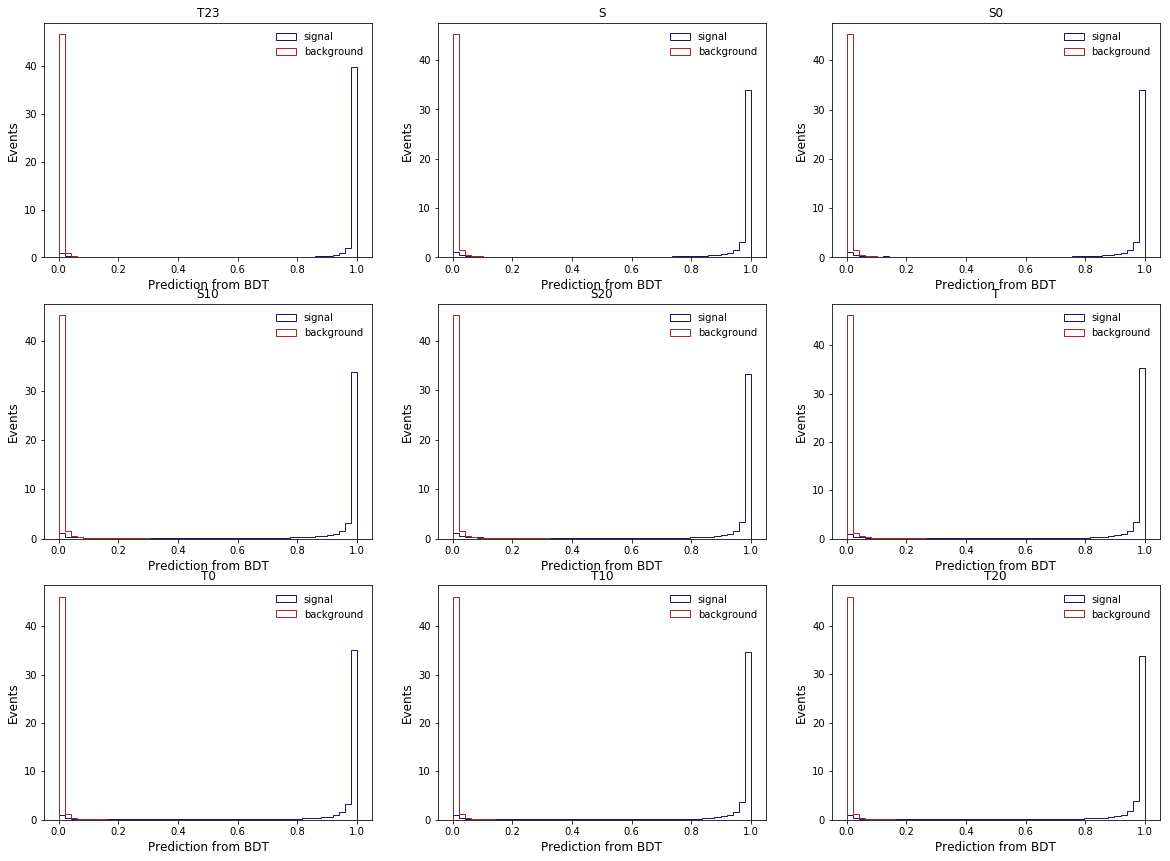

In [12]:
plt.figure(figsize=(20,25));
for i in algo:
# plot all predictions (both signal and background)
    
    plt.subplot(5,3,i+1)
# plot signal and background separately
    plt.hist(predictions[i][test[i].get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal', density=True);
    plt.hist(predictions[i][~(test[i].get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background', density=True);
# make the plot readable
    plt.xlabel('Prediction from BDT',fontsize=12);
    plt.ylabel('Events',fontsize=12);
    plt.title(algo_name[i])
    plt.legend(frameon=False);
plt.savefig(fig_dir+'/predictions.png')

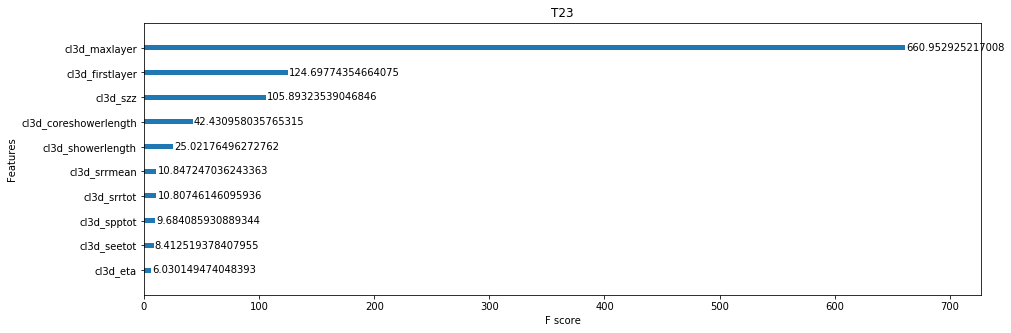

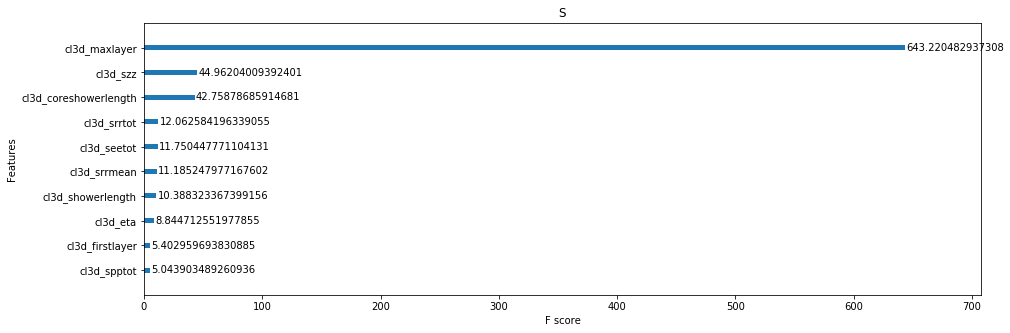

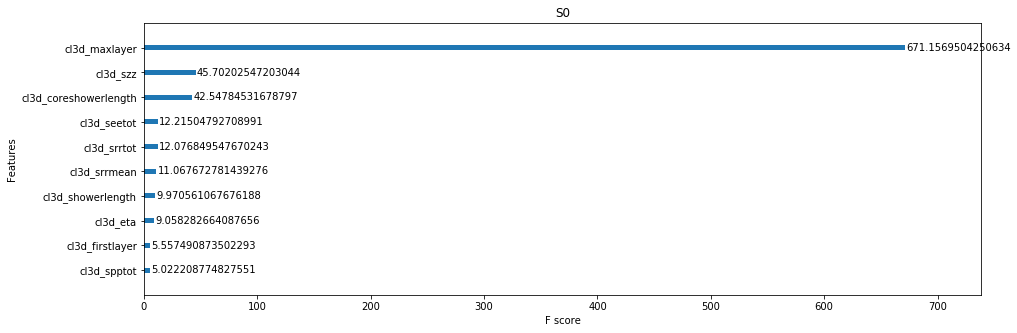

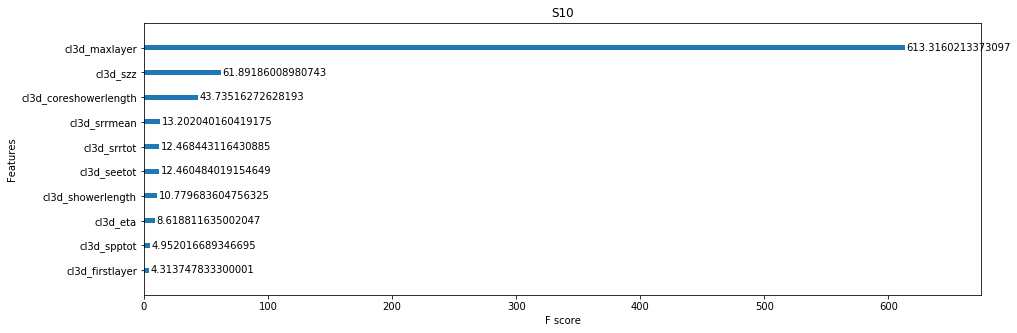

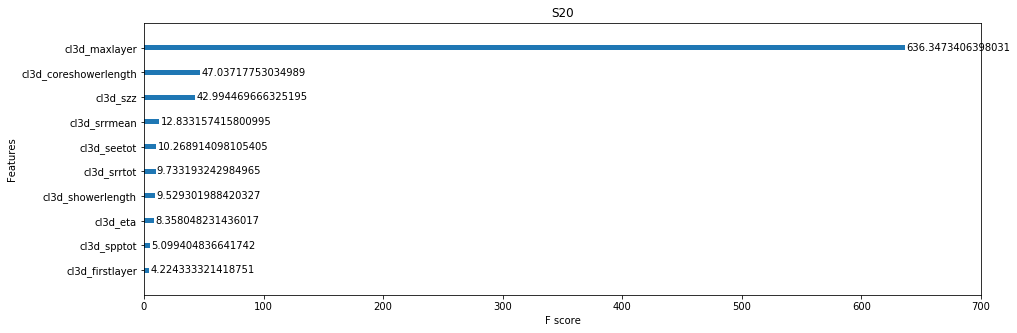

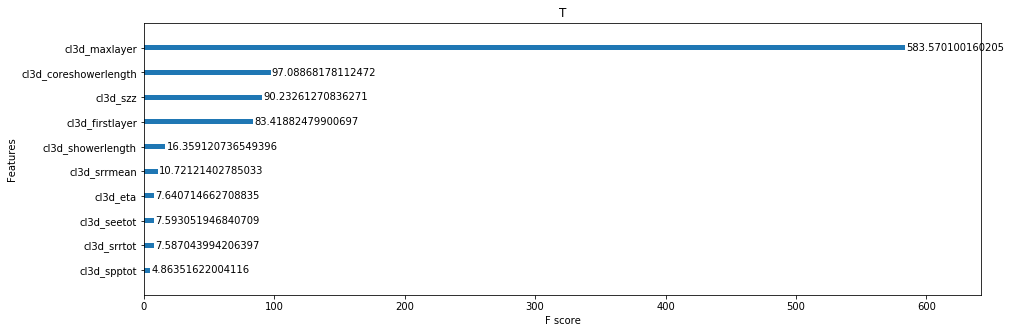

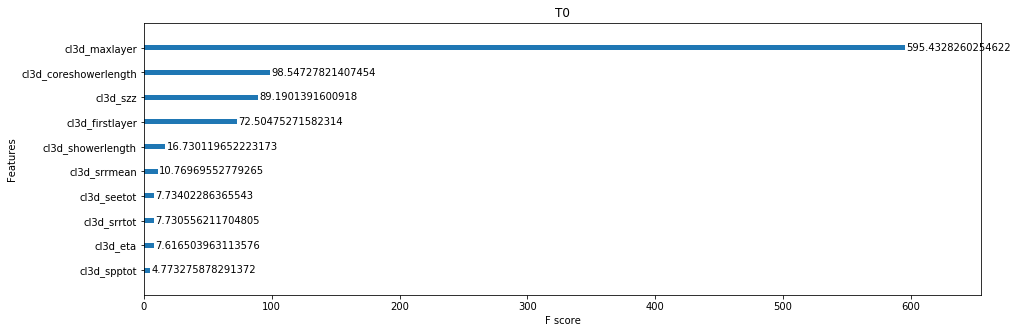

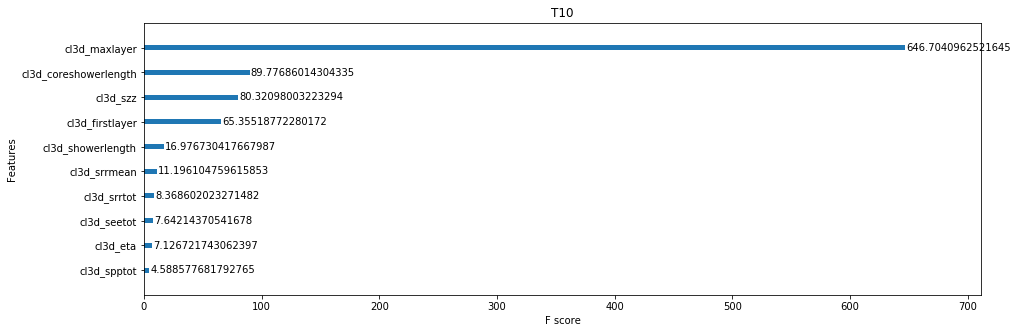

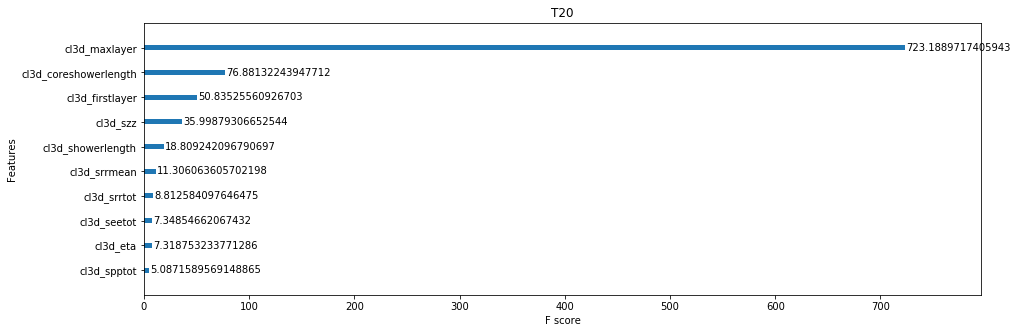

In [13]:
#plot importance of features for each algo
os.makedirs(fig_dir+'/importance', exist_ok=True)
for i in algo:
    plt.figure(figsize=(15,5))
    ax=plt.subplot(111)
    xgb.plot_importance(booster[i],ax,grid=False, title=algo_name[i], importance_type='gain');
    plt.savefig(fig_dir+'/importance/{}.png'.format(algo_name[i]))

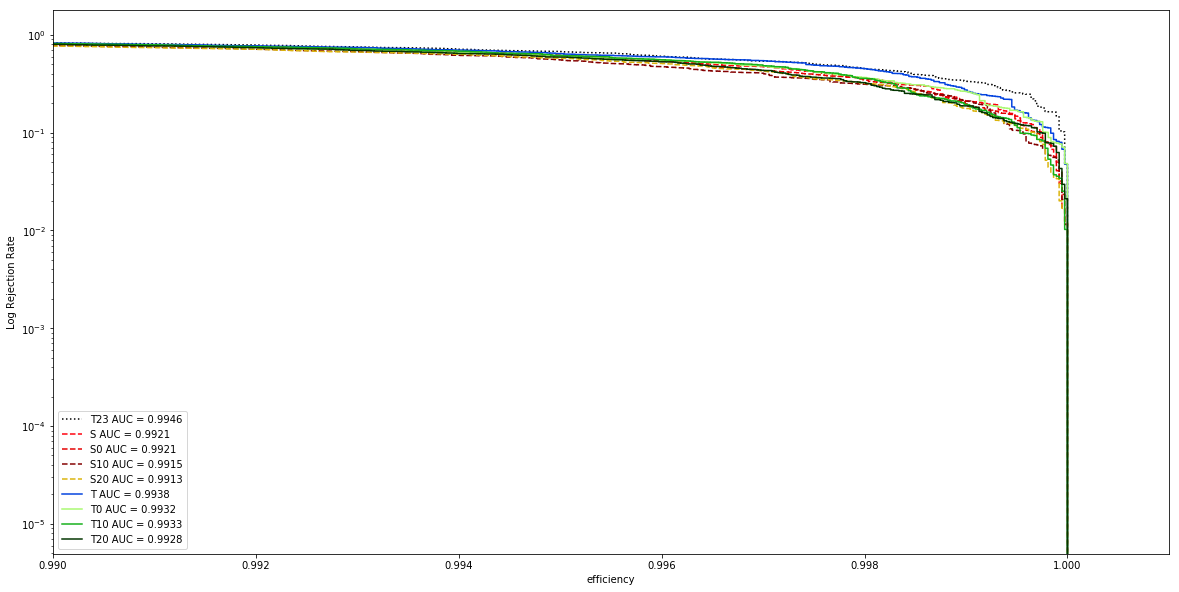

In [25]:
#build ROC
color=['black', 'xkcd:bright red', 'xkcd:red', 'xkcd:dark red', 'xkcd:gold','xkcd:blue',
       'xkcd:spring green', 'xkcd:green', 'xkcd:dark green']
style=[':' ,'--','--','--','--','-','-','-','-']
plt.figure(figsize=(20,10))
for i in algo:
    #buildROC(y_test[i], predictions[i])
    fpr, tpr, threshold = metrics.roc_curve(y_test[i],predictions[i])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(tpr,(1-fpr), label ='%s AUC = %0.4f' %(algo_name[i],roc_auc), c=color[i], linestyle=style[i])
plt.legend(loc = 'lower left')
    #plt.plot([0, 1], [0, 1],'r--')
plt.xlim(0.99,1.001)
plt.yscale('log')
    #plt.ylim(0.6,1.05)
plt.xlabel('efficiency')
plt.ylabel('Log Rejection Rate') 
plt.savefig(fig_dir+'/ROC.png')

In [15]:
def score(ytest, ypred, thr):
    fpr, tpr, threshold = metrics.roc_curve(ytest,ypred)
    roc=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    roc_cut=roc[roc['tpr']>thr];
    score=np.min(roc_cut['fpr']);
    return score

rejection rate for T23 at 0.995 threshold= 0.32344000849938614
rejection rate for S at 0.995 threshold= 0.3969179717200771
rejection rate for S0 at 0.995 threshold= 0.37951136129203383
rejection rate for S10 at 0.995 threshold= 0.4447529526891799
rejection rate for S20 at 0.995 threshold= 0.4217417307709305
rejection rate for T at 0.995 threshold= 0.3557405061426509
rejection rate for T0 at 0.995 threshold= 0.39414044983597274
rejection rate for T10 at 0.995 threshold= 0.3836007350602537
rejection rate for T20 at 0.995 threshold= 0.4059088898717382


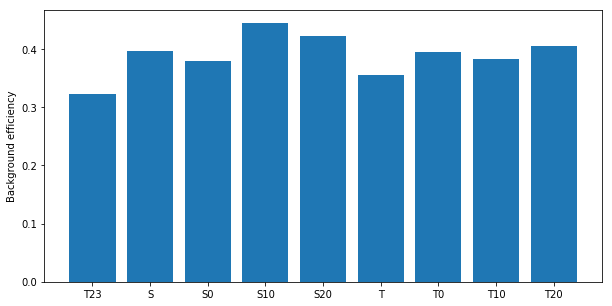

In [16]:
thr=0.995
scor=[]
for i in algo:
    scor.append(score(y_test[i], predictions[i],thr))
    print('rejection rate for %s at %0.3f threshold=' %(algo_name[i],thr) ,scor[i])


#plot background efficiency
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(algo_name)), scor)
plt.xticks(np.arange(len(algo_name)), algo_name);
plt.ylabel('Background efficiency')
plt.savefig(fig_dir+'/efficiency.png')

In [17]:
#CALCULATE ERROR BARS

from scipy import stats
#normal
#def error(total, score, conf_level):
#    alpha=(1-conf_level)/2
#    sigma=np.sqrt(score*(1-score)/total)
#    delta=np.abs(score-stats.norm.ppf(1-alpha,loc=score, scale=sigma))
#    return delta

#clopper pearson
def error(total, score, conf_level):
    alpha=(1-conf_level)/2
    n=total
    k=score*n
    lo = score-stats.beta.ppf(alpha/2, k, n-k+1)
    hi = stats.beta.ppf(1 - alpha/2, k+1, n-k)-score
    return lo, hi

old bdt score: 0.06770983589051974


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


Text(0, 0.5, 'Log Rejection Rate')

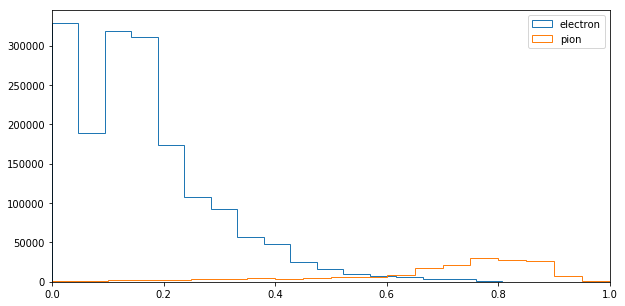

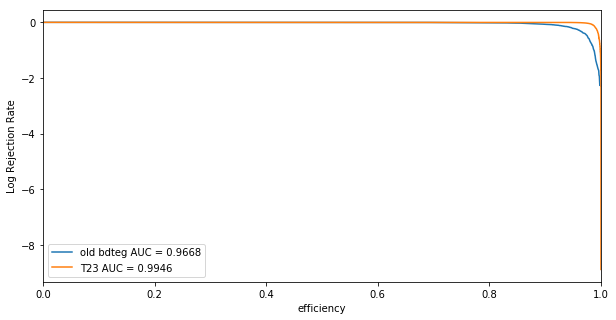

In [18]:
#comparison with old 2d3d algo
thr=0.9
#make the comparison
b=algo_cut[0].dropna()
a=b['cl3d_bdteg']
c=np.interp(a, (a.min(), a.max()), (1, 0))

score_old=score(b['genpart_pid'],c,thr)
print('old bdt score:', score_old)

i=0
nbins=20
plt.figure(figsize=(10,5))
plt.hist(c[b['genpart_pid']==0],histtype='step', bins=nbins, label='electron');
plt.hist(c[b['genpart_pid']==1],histtype='step',  bins=nbins, label='pion');
plt.legend()
plt.xlim(0,1)
i=0

plt.figure(figsize=(10,5))
fpr, tpr, threshold = metrics.roc_curve(b['genpart_pid'],c)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(tpr,np.log(1-fpr), label ='old bdteg AUC = %0.4f' %(roc_auc))

fpr, tpr, threshold = metrics.roc_curve(y_test[i],predictions[i])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(tpr,np.log(1-fpr), label ='%s AUC = %0.4f' %(algo_name[i],roc_auc))
    
plt.legend(loc = 'lower left')
    #plt.plot([0, 1], [0, 1],'r--')
plt.xlim(0,1)
    #plt.ylim(0.6,1.05)
plt.xlabel('efficiency')
plt.ylabel('Log Rejection Rate')  
#plt.savefig(fig_dir+'/old_roc.png')

In [19]:
def binning_pt(algo, thr, n_bins, a):
    pt_max=np.max(X_pt[i])
    pt_min=np.min(X_pt[i])
    range_pt= pt_max-pt_min
    if a != 1:
        x = (a-1)/((a**n_bins)-1)
    else: x = 1/n_bins
    bins_pt=[]
    score_pt=[]
    y_err_pt=[]
    y_err_pt_lo=[]
    y_err_pt_hi=[]
    pred_pt={}
    y_test_pt={}
    bin_end = pt_min
    
    
    for k in range(n_bins):
        bin_start = bin_end
        bin_end = bin_start + (a**k)*range_pt*x
        bins_pt.append((bin_start+bin_end)/2)
        sel=(X_pt[i] >= (bin_start)) & (X_pt[i] < (bin_end))
        pred_pt[k]=predictions[i][sel]    
        y_test_pt[k]=y_test[i][sel]
        score_pt.append(score(y_test_pt[k], pred_pt[k],thr))
        lo,hi=error(y_test_pt[k].shape[0], score(y_test_pt[k], pred_pt[k], thr), conf_level)
        y_err_pt_lo.append(lo)
        y_err_pt_hi.append(hi)
        y_err_pt=[y_err_pt_lo, y_err_pt_hi]
    return bins_pt, score_pt, y_err_pt


In [20]:
def binning_eta(algo, thr, n_bins, a):
    X_test[i]['abseta']=np.abs(X_test[i]['cl3d_eta'])
    eta_max=np.max(X_test[i]['abseta'])
    eta_min=np.min(X_test[i]['abseta'])
    range_eta= eta_max-eta_min
    if a != 1:
        x = (a-1)/((a**n_bins)-1)
    else: x = 1/n_bins
    bins_eta=[]
    score_eta=[]
    y_err_eta=[]
    y_err_eta_lo=[]
    y_err_eta_hi=[]
    pred_eta={}
    y_test_eta={}
    bin_end = eta_min
    
    
    for k in range(n_bins):
        bin_start = bin_end
        bin_end = bin_start + (a**k)*range_eta*x
        bins_eta.append((bin_start+bin_end)/2)
        sel=(X_test[i]['abseta'] > (bin_start)) & (X_test[i]['abseta'] < (bin_end))
        pred_eta[k]=predictions[i][sel]    
        y_test_eta[k]=y_test[i][sel]
        #print(pred_pt[k].shape[0])
        score_eta.append(score(y_test_eta[k], pred_eta[k],thr))
        #print('rejection rate for pt bin %d at %0.3f threshold=' %(j+1,thr),  score_pt[j])
        lo,hi=error(y_test_eta[k].shape[0], score(y_test_eta[k], pred_eta[k], thr), conf_level)
        y_err_eta_lo.append(lo)
        y_err_eta_hi.append(hi)
        y_err_eta=[y_err_eta_lo, y_err_eta_hi]
    return bins_eta, score_eta, y_err_eta

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/matplotlib/ticker.py:1154: RuntimeWarning: divide by zero encountered in log10
  s = '$10^{{{:.0f}}}$'.format(np.log10(x))
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


CPU times: user 8.58 s, sys: 4.48 s, total: 13.1 s
Wall time: 6.46 s


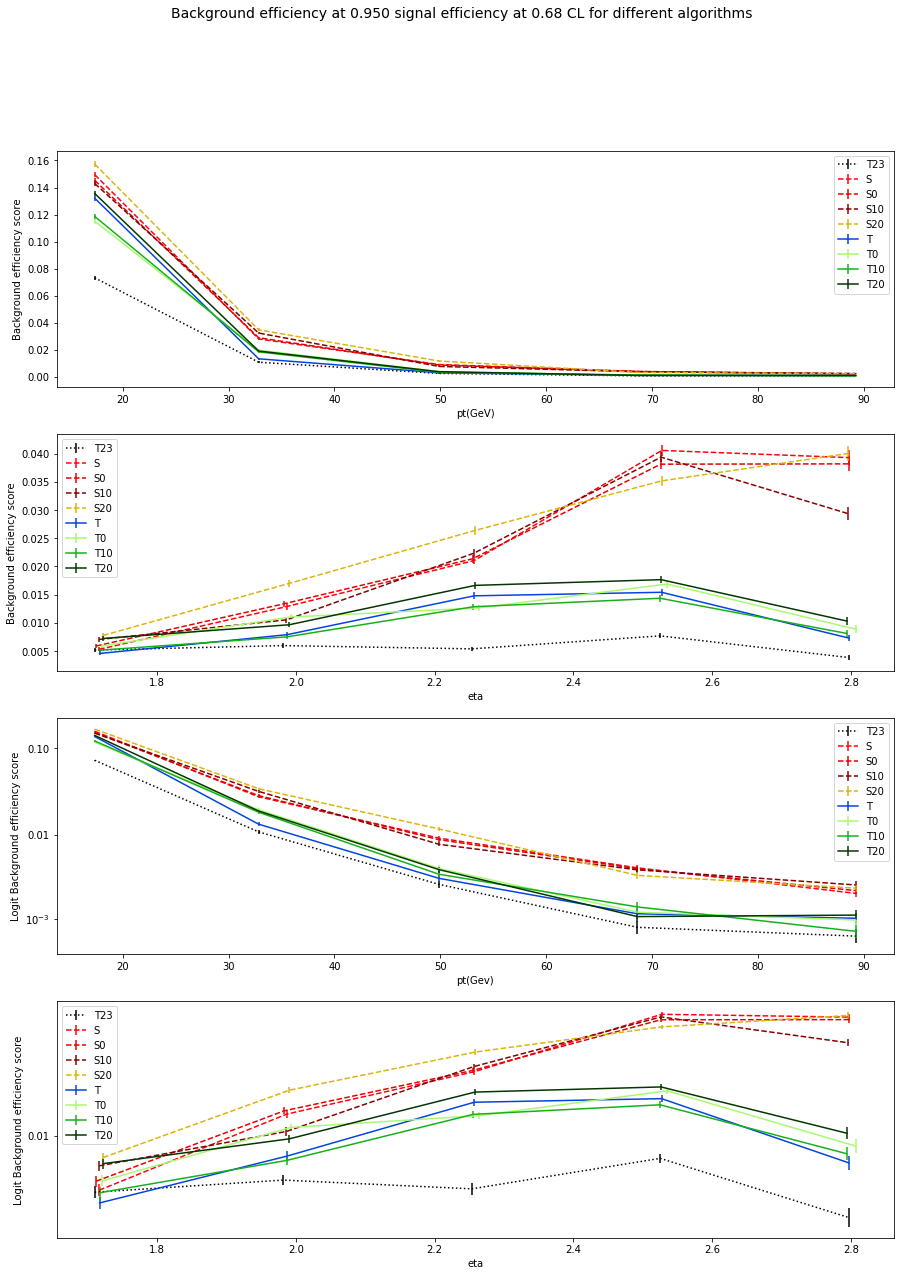

In [21]:
%%time
#plot score
os.makedirs(fig_dir+'/score', exist_ok=True)
%matplotlib inline
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(15,20))
thr=0.95
nbins=5
a = 1.1 #increasing factor
conf_level=0.682689492137


color=['black', 'xkcd:bright red', 'xkcd:red', 'xkcd:dark red', 'xkcd:gold','xkcd:blue',
       'xkcd:spring green', 'xkcd:green', 'xkcd:dark green']
style=[':' ,'--','--','--','--','-','-','-','-']

for i in algo:
    
    bins_pt, score_pt, y_err_pt=binning_pt(i, thr, nbins, a)
    bins_eta, score_eta, y_err_eta=binning_eta(i, thr, nbins, 1)
    
        
    plt.subplot(411);
    plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Background efficiency score');
    plt.xlabel('pt(GeV)');
    #plt.ylim(-0.01,0.2)
    #plt.xlim(right=100)
    plt.legend()
    
    plt.subplot(412);
    plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Background efficiency score');
    plt.xlabel('eta');
    #plt.ylim(0,0.1)
    plt.legend()
    #plt.xlim(right=3.0)
    
    plt.subplot(413);
    plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Logit Background efficiency score');
    plt.xlabel('pt(Gev)');
    #plt.xlim(right=100)
    plt.yscale('logit')
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
    #plt.ylim(0.00001,0.4)
    plt.legend()
    
    plt.subplot(414);
    plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Logit Background efficiency score');
    plt.xlabel('eta');
    plt.yscale('logit')
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
    #plt.ylim(0.001,0.2)
    #plt.xlim(right=3.0)
    plt.legend()
    
   
    
    plt.suptitle('Background efficiency at %0.3f signal efficiency at %0.2f CL for different algorithms' %(thr, conf_level), fontsize=14)
    plt.savefig(fig_dir+'/score/Algo_comparison_{}WP.png'.format(thr))

CPU times: user 8.48 s, sys: 4.47 s, total: 13 s
Wall time: 6.34 s


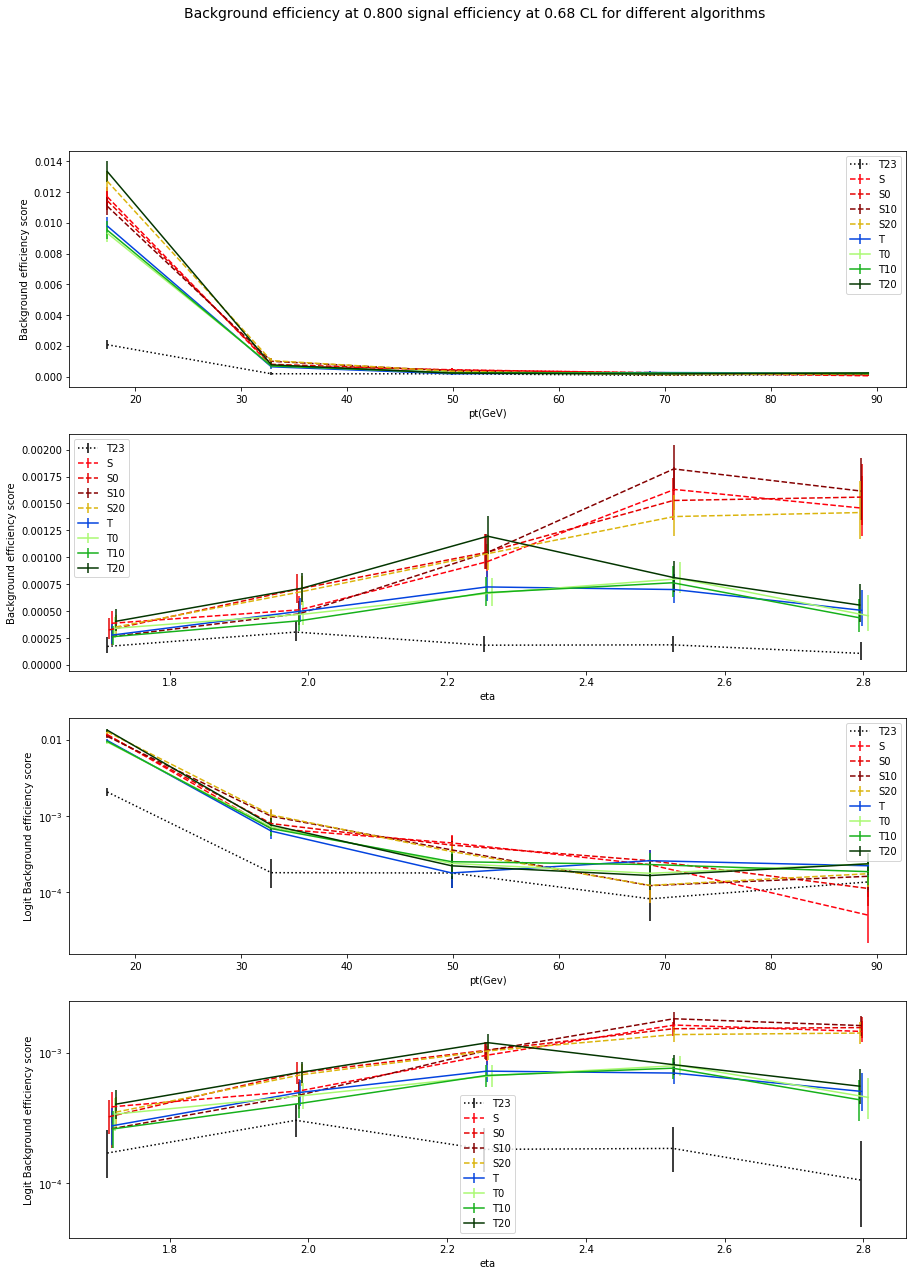

In [22]:
%%time
#plot score
os.makedirs(fig_dir+'/score', exist_ok=True)
%matplotlib inline
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(15,20))
thr=0.8
nbins=5
a = 1.1 #increasing factor
conf_level=0.682689492137


color=['black', 'xkcd:bright red', 'xkcd:red', 'xkcd:dark red', 'xkcd:gold','xkcd:blue',
       'xkcd:spring green', 'xkcd:green', 'xkcd:dark green']
style=[':' ,'--','--','--','--','-','-','-','-']

for i in algo:
    
    bins_pt, score_pt, y_err_pt=binning_pt(i, thr, nbins, a)
    bins_eta, score_eta, y_err_eta=binning_eta(i, thr, nbins, 1)
    
        
    plt.subplot(411);
    plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Background efficiency score');
    plt.xlabel('pt(GeV)');
    #plt.ylim(-0.01,0.2)
    #plt.xlim(right=100)
    plt.legend()
    
    plt.subplot(412);
    plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Background efficiency score');
    plt.xlabel('eta');
    #plt.ylim(0,0.1)
    plt.legend()
    #plt.xlim(right=3.0)
    
    plt.subplot(413);
    plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Logit Background efficiency score');
    plt.xlabel('pt(Gev)');
    #plt.xlim(right=100)
    plt.yscale('logit')
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
    #plt.ylim(0.00001,0.4)
    plt.legend()
    
    plt.subplot(414);
    plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Logit Background efficiency score');
    plt.xlabel('eta');
    plt.yscale('logit')
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
    #plt.ylim(0.001,0.2)
    #plt.xlim(right=3.0)
    plt.legend()
    
   
    
    plt.suptitle('Background efficiency at %0.3f signal efficiency at %0.2f CL for different algorithms' %(thr, conf_level), fontsize=14)
    plt.savefig(fig_dir+'/score/Algo_comparison_{}WP.png'.format(thr))

CPU times: user 5.61 s, sys: 3.01 s, total: 8.62 s
Wall time: 4.2 s


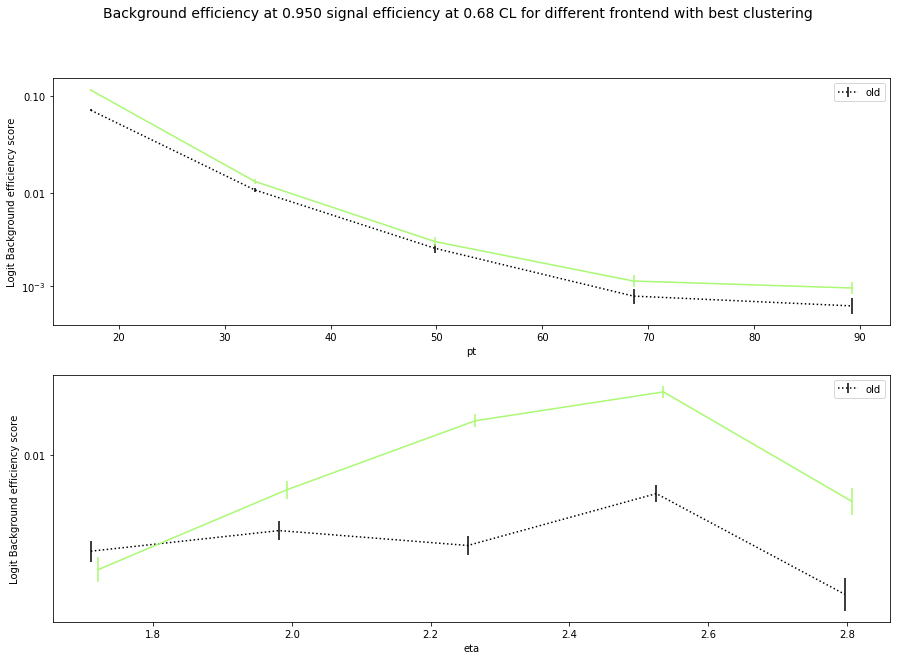

In [23]:
%%time
#plot score
%matplotlib inline
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(15,10))
thr=0.95
nbins=5
conf_level=0.682689492137
pred_pt={}
y_test_pt={}
bins_pt={}
score_pt={}
y_err_pt={}
score_pt_best=[]
score_eta_best=[]
color=['black', 'xkcd:bright red', 'xkcd:red', 'xkcd:dark red', 'xkcd:gold','xkcd:blue',
       'xkcd:spring green', 'xkcd:green', 'xkcd:dark green']
style=[':' ,'--','--','--','--','-','-','-','-']
frontend=['old','','','','SuperTC','','','','Threshold']
for i in algo:
    
    bins_pt, score_pt, y_err_pt=binning_pt(i, thr, nbins, a)
    bins_eta, score_eta, y_err_eta=binning_eta(i, thr, nbins, 1)
        
    if i == 0 or i==1 or i ==7:
        score_pt_best=score_pt
        score_eta_best=score_eta
    else: 
        score_pt_best=np.minimum(score_pt_best, score_pt)
        score_eta_best=np.minimum(score_eta_best, score_eta)
    
    if i == 0  or i==6 or i==12:
        plt.subplot(211);
        plt.errorbar(bins_pt, score_pt_best, y_err_pt, label=frontend[i],c=color[i], fmt=style[i]);
        plt.ylabel('Logit Background efficiency score');
        plt.xlabel('pt');
        #plt.xlim(right=100)
        plt.yscale('logit')
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
        #plt.ylim(0.00001,0.2)
        plt.legend()

        plt.subplot(212);
        plt.errorbar(bins_eta, score_eta_best, y_err_eta, label=frontend[i],c=color[i], fmt=style[i]);
        plt.ylabel('Logit Background efficiency score');
        plt.xlabel('eta');
        plt.yscale('logit')
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
        #plt.ylim(0.0005,0.1)
        #plt.xlim(right=2.9)
        plt.legend()

   
    
    plt.suptitle('Background efficiency at %0.3f signal efficiency at %0.2f CL for different frontend with best clustering' %(thr, conf_level), fontsize=14)
    plt.savefig(fig_dir+'/score/Algo_comparison_{}WP_best.png'.format(thr))

CPU times: user 5.5 s, sys: 2.96 s, total: 8.46 s
Wall time: 4.09 s


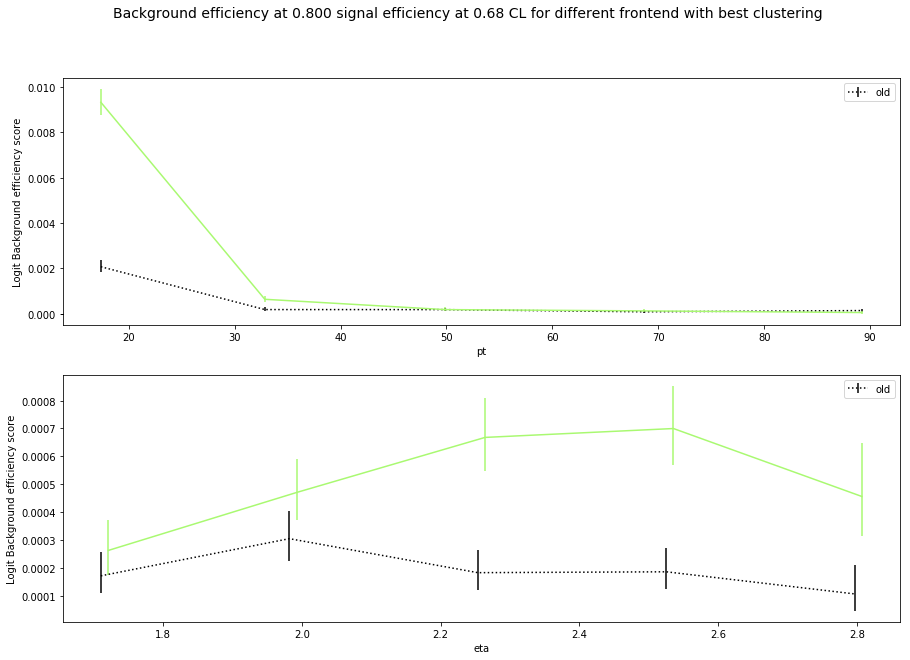

In [24]:
%%time
#plot score
%matplotlib inline
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(15,10))
thr=0.8
nbins=5
conf_level=0.682689492137
pred_pt={}
y_test_pt={}
bins_pt={}
score_pt={}
y_err_pt={}
score_pt_best=[]
score_eta_best=[]
color=['black', 'xkcd:bright red', 'xkcd:red', 'xkcd:dark red', 'xkcd:gold','xkcd:blue',
       'xkcd:spring green', 'xkcd:green', 'xkcd:dark green']
style=[':' ,'--','--','--','--','-','-','-','-']
frontend=['old','','','','SuperTC','','','','Threshold']
for i in algo:
    
    bins_pt, score_pt, y_err_pt=binning_pt(i, thr, nbins, a)
    bins_eta, score_eta, y_err_eta=binning_eta(i, thr, nbins, 1)
    #print(score_pt)
    if i == 0 or i==1 or i ==7:
        score_pt_best=score_pt
        score_eta_best=score_eta
    else: 
        score_pt_best=np.minimum(score_pt_best, score_pt)
        score_eta_best=np.minimum(score_eta_best, score_eta)
    #print(score_pt_best, score_eta_best)
    if i == 0  or i==6 or i==12:
        plt.subplot(211);
        plt.errorbar(bins_pt, score_pt_best, y_err_pt, label=frontend[i],c=color[i], fmt=style[i]);
        plt.ylabel('Logit Background efficiency score');
        plt.xlabel('pt');
        #plt.xlim(right=100)
        #plt.yscale('logit')
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
        #plt.ylim(0.00001,0.2)
        plt.legend()

        plt.subplot(212);
        plt.errorbar(bins_eta, score_eta_best, y_err_eta, label=frontend[i],c=color[i], fmt=style[i]);
        plt.ylabel('Logit Background efficiency score');
        plt.xlabel('eta');
        #plt.yscale('logit')
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
        #plt.ylim(0.0005,0.1)
        #plt.xlim(right=2.9)
        plt.legend()

   
    
    plt.suptitle('Background efficiency at %0.3f signal efficiency at %0.2f CL for different frontend with best clustering' %(thr, conf_level), fontsize=14)
    plt.savefig(fig_dir+'/score/Algo_comparison_{}WP_best.png'.format(thr))